# **Bottle-gourd Disease Detection using custom CNN models** 

In [1]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-hlv3nzpq
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-hlv3nzpq
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:0000:0100:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:0000:0100:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00:00:

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from lime import lime_image
import zipfile
import os
from tqdm import tqdm  # Import tqdm for progress bars

## Pre-Processing and Load the Dataset

In [3]:
# Define transformations with potential augmentations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),      
    transforms.RandomHorizontalFlip(),     
    transforms.ToTensor(),                  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),         
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/input/bottle-gourd/Bottle gourd", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
# Apply test transformation to validation and test sets

val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Data Visualization for each class

['Anthracnose', 'Downey mildew', 'Fresh leaf']
{'Anthracnose': 0, 'Downey mildew': 1, 'Fresh leaf': 2}
3


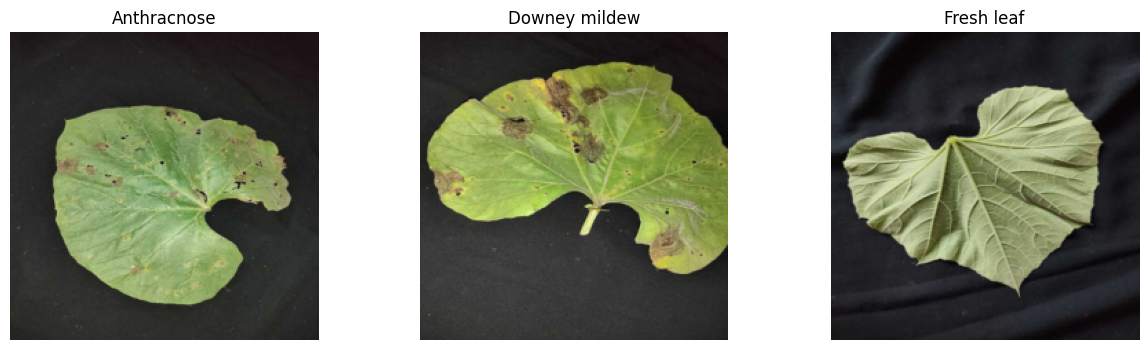

In [4]:
class_names = dataset.classes
print(class_names)
print(dataset.class_to_idx)
# Output: {'anthracnose': 0, 'downey mildew': 1, 'fresh leaf': 2}
num_classes = len(class_names)
print(num_classes)
fig, axs = plt.subplots(1, num_classes, figsize=(15, 4))
# Dictionary to track displayed images per class
displayed_classes = {class_name: False for class_name in class_names}

# Loop through the data to get at least one sample from each class
for images, labels in train_loader:
    for img, label in zip(images, labels):
        class_name = class_names[label]
        # Display the image if not already displayed for this class
        if not displayed_classes[class_name]:
            img = img.permute(1, 2, 0).numpy()
            img = (img * 0.5) + 0.5  # Unnormalize the image
            axs[label].imshow(np.clip(img, 0, 1))  # Clip to valid range
            axs[label].set_title(class_name)
            axs[label].axis('off')
            displayed_classes[class_name] = True  # Mark as displayed

        # Break if all classes are displayed
        if all(displayed_classes.values()):
            break

    if all(displayed_classes.values()):
        break
plt.show()

## Define a Custom CNN model

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 14 * 14, 512)  # ✅ 14x14 from input 224x224 after 4 poolings
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)  # Change 10 → your number of classes
        
        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)  # Flatten dynamically
        

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)

        return x

## Transfer Learning Model

In [15]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [23]:
import torch.nn as nn
import timm

def get_transfer_model(model_name, num_classes):
    if model_name == "resnext101_32x8d":
        model = timm.create_model("resnext101_32x8d", pretrained=True)
        model.fc = nn.Linear(model.get_classifier().in_features, num_classes)

    elif model_name == "densenet201":
        model = timm.create_model("densenet201", pretrained=True)
        model.classifier = nn.Linear(model.get_classifier().in_features, num_classes)

    elif model_name == "efficientnetv2_s":
        model = timm.create_model("efficientnetv2_s", pretrained=True)
        model.classifier = nn.Linear(model.get_classifier().in_features, num_classes)

    elif model_name == "nasnetalarge":
        model = timm.create_model("nasnetalarge", pretrained=True)
        model.last_linear = nn.Linear(model.get_classifier().in_features, num_classes)

    elif model_name == "convnext_base":
        model = timm.create_model("convnext_base", pretrained=True)
        model.head = nn.Linear(model.get_classifier().in_features, num_classes)

    elif model_name == "xception":
        model = timm.create_model("xception", pretrained=True)
        model.fc = nn.Linear(model.get_classifier().in_features, num_classes)

    else:
        raise ValueError(f"Model '{model_name}' not supported. Please check the name.")

    return model


## Traing and Early Stopping

In [36]:
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


# Train the Model and Plot Loss Curves

## Training using Custom Model (Slow Without AMP)

In [37]:
# Set number of epochs and initialize variables

num_epochs = 10  # Define the number of training epochs

model = CustomCNN()  # Initialize the model; can replace with a transfer model like get_transfer_model()

criterion = nn.CrossEntropyLoss()  # Loss function

optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer with learning rate

early_stopping = EarlyStopping(patience=5)  # Initialize early stopping with patience

train_losses, val_losses = [], []  # Lists to store training and validation losses per epoch

# Loop over epochs
for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}/{num_epochs}")
    # Training phase

    model.train()  # Set model to training mode

    train_loss = 0  # Initialize cumulative training loss for the epoch

    # Loop over training data with tqdm progress bar
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Backward pass (calculate gradients)
        optimizer.step()  # Update weights
        train_loss += loss.item()  # Accumulate the training loss

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0  # Initialize cumulative validation loss for the epoch
    with torch.no_grad():  # Disable gradient calculation for validation

        # Loop over validation data with tqdm progress bar
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            val_loss += loss.item()  # Accumulate the validation loss

    # Calculate average losses and append to lists
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    progress = ((epoch + 1) / num_epochs) * 100
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} - Progress: {progress:.2f}%")


    # Early stopping check
    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break


Epoch 1/10


Epoch [1/10] - Train Loss: 1.4278, Val Loss: 1.1311 - Progress: 10.00%
Epoch 2/10


Epoch [2/10] - Train Loss: 0.9813, Val Loss: 0.5770 - Progress: 20.00%
Epoch 3/10


Epoch [3/10] - Train Loss: 0.6408, Val Loss: 0.4504 - Progress: 30.00%
Epoch 4/10


Epoch [4/10] - Train Loss: 0.4108, Val Loss: 0.3619 - Progress: 40.00%
Epoch 5/10


Epoch [5/10] - Train Loss: 0.2757, Val Loss: 0.0997 - Progress: 50.00%
Epoch 6/10


Epoch [6/10] - Train Loss: 0.1661, Val Loss: 0.3830 - Progress: 60.00%
Epoch 7/10


Epoch [7/10] - Train Loss: 0.1071, Val Loss: 0.0763 - Progress: 70.00%
Epoch 8/10


Epoch [8/10] - Train Loss: 0.0414, Val Loss: 0.0996 - Progress: 80.00%
Epoch 9/10


Epoch [9/10] - Train Loss: 0.2316, Val Loss: 0.4341 - Progress: 90.00%
Epoch 10/10


Epoch [10/10] - Train Loss: 0.1026, Val Loss: 0.0060 - Progress: 100.00%


In [38]:
# Define a path for saving the model
model_save_path = "custom_cnn_model.pth"  # You can specify a different path or filename

# Save the model after training completes or early stopping is triggered
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to custom_cnn_model.pth


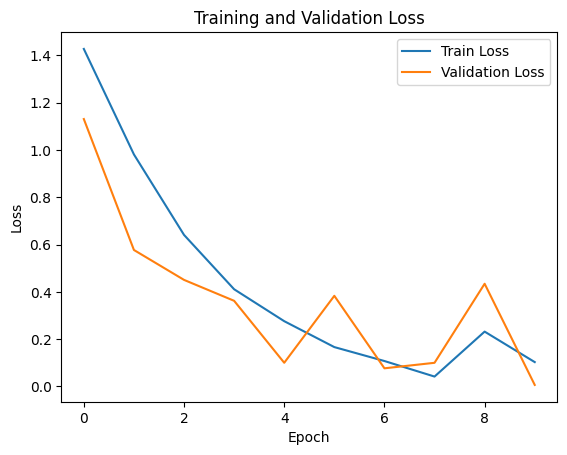

In [39]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()